
## Import libraries
---

In [1]:
!pip install pyspark
!pip install opendatasets
import re
import os
import gc
import sys
import time
import pyspark

import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.context import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, when
from numpy.polynomial.polynomial import polyfit
from pyspark.ml.functions import vector_to_array
from sklearn.decomposition import PCA as sklearn_pca
from pyspark.ml.feature import PCA as spark_pca
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import feature, regression, Pipeline, classification, pipeline, evaluation
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, ChiSqSelector, VectorAssembler, PCA

## Initialize Spark class instance and obtain the dataset
---

In [2]:
sc = SparkContext()
spark = SparkSession(sc)
od.download("https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction")
root_path = "/content/airline-passenger-satisfaction"

# Getting some overviews of the data
# Drop NA entries of the dataset, index and ID columns
df = pd.read_csv(root_path+'/test.csv')
df = df.dropna()
df = df.drop(['Unnamed: 0', 'id'], axis=1)
df.head()

Skipping, found downloaded files in "./airline-passenger-satisfaction" (use force=True to force download)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


## Get an overview of the distribution of the satisfaction within columns


---

The overall distribution of the two classes is balanced with approximately 20% of the difference in amount, while it is not so balanced when statistic is done inside each attributes seperately. 

#### **Type of Travel**
The number of people having business trip is larger than the number of people having personal trip. People having business trip tend to give more positive feedback while the most portion of the people with personal purpose give negative feedback. This attribute will be a important explanatory variable when predicting satisfaction level.

#### **Gender**
The number of Female and Male is well-balanced. The ratio of positive and negative feedback differed by gender was not significant.

#### **Customer Type**
Disloyal customers are more likely to give negative feedbacks while loyal customers give evenly distributed pos/neg feedbacks. 

#### **Class**
Feedback given by people in different classes showed a completely different distribution. The sample size for Eco class and Business class is about the same, while the sample size for Eco Plus class is relatively small.



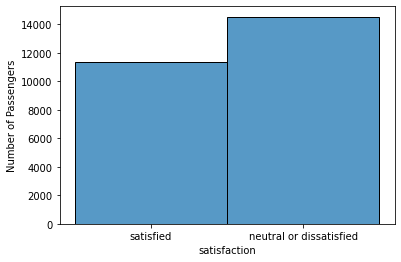

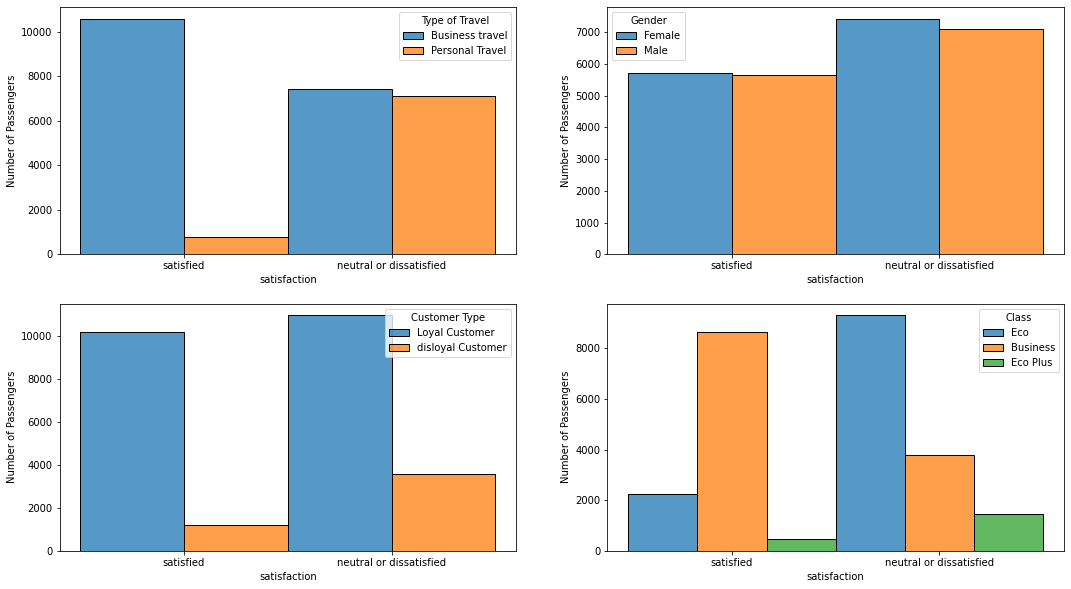

In [3]:
sns.histplot(df['satisfaction'], bins=3).set(ylabel='Number of Passengers')
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.histplot(ax=axes[0, 0], x=df['satisfaction'], hue=df['Type of Travel'], multiple="dodge").set(ylabel='Number of Passengers')
sns.histplot(ax=axes[0, 1], x=df['satisfaction'], hue=df['Gender'], multiple="dodge").set(ylabel='Number of Passengers')
sns.histplot(ax=axes[1, 0], x=df['satisfaction'], hue=df['Customer Type'], multiple="dodge").set(ylabel='Number of Passengers')
sns.histplot(ax=axes[1, 1], x=df['satisfaction'], hue=df['Class'], multiple="dodge").set(ylabel='Number of Passengers')
plt.show()

## Perform Independent Component Analysis 


---


To further implement model training, one has to make sure that attributes are linearly independent with each others. By plotting heatmap of correlation coefficient, the columns "***Departure Delay in Minutes***" and "***Arrival Delay in Minutes***" do not meet the requirement with the correlation coefficient of 0.96. 

The explanatory/independent variable is apparently the "***Departure Delay in Minutes***" column. Therefore, the dependent variable column ("***Arrival Delay in Minutes***") will be dropped when training the model.

Text(0, 0.5, 'Arrival Delay in Minutes')

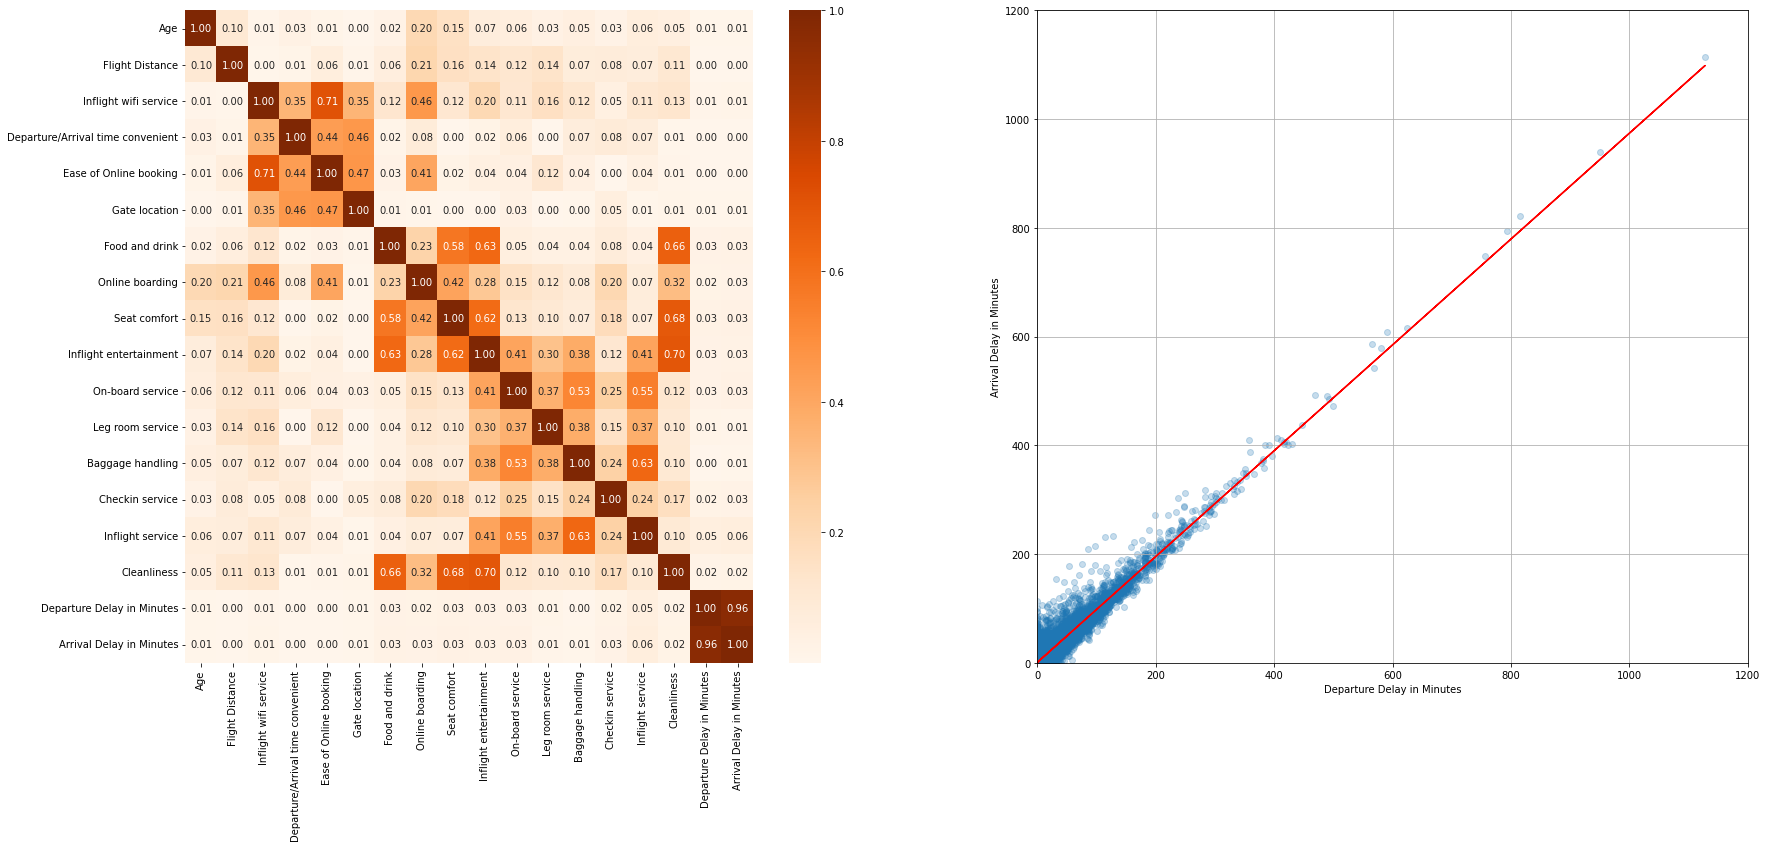

In [4]:
plt.figure(figsize=(28, 12))
plt.subplot(1, 2, 1)
sns.heatmap(abs(df.corr()), cmap='Oranges', square=False, annot=True, fmt='.2f')

plt.subplot(1, 2, 2)
x = df['Departure Delay in Minutes']
y = df['Arrival Delay in Minutes']
b, k = polyfit(x, y, 1)
plt.scatter(x, y, alpha = 0.25)
plt.plot(x, b + k * x, '-', c='r')
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.grid(True)
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('Arrival Delay in Minutes')

## PCA Analysis
---
By plotting variance explanation graph, 99.99% of the variance can be explained using the first three components. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


(0.9999, 1.0)

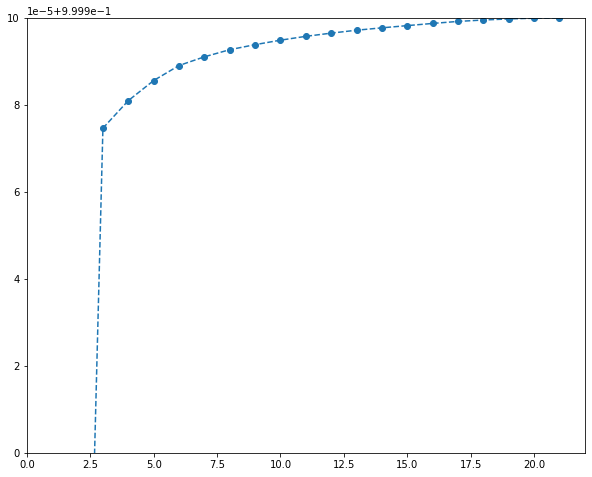

In [5]:
df['Gender'].replace(['Female', 'Male'],[0, 1], inplace=True)
df['Customer Type'].replace(['Loyal Customer', 'disloyal Customer'],[0, 1], inplace=True)
df['Type of Travel'].replace(['Business travel', 'Personal Travel'],[0, 1], inplace=True)
df['Class'].replace(['Eco', 'Eco Plus', 'Business'],[0, 1, 2], inplace=True)
df_x = df.drop(['satisfaction', 'Arrival Delay in Minutes'], 1, inplace=False)
pca = sklearn_pca() # init pca
pca.fit(df_x)

plt.figure(figsize=(10, 8))
cumulativeValue = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1,22), cumulativeValue, marker = 'o', linestyle="--")
plt.ylim(0.9999, 1)

## Load the dataset (Pyspark Dataframe)
---
Preprocessing is needed after reading in the dataset as a pyspark dataframe. Some attributes are in string type. The function *categorize_dataframe* converts the following attributes by mapping them to [0, 1, 2, ... ]. Also, index, ID and linearly dependent columns are dropped before training the model. 


*   Gender:  *Female, male*
*   Customer Type:  *Loyal Customer, disloyal Customer*
*   Type of Travel:  *Personal Travel, Business travel*
*   Class:  *Eco, Eco Plus, Business*
*   satisfaction:  *satisfied, unsatisfied*



In [ ]:
df_train = spark.read.csv(path=root_path+"/train.csv", inferSchema =True, header=True).cache()
df_test = spark.read.csv(path=root_path+"/test.csv", inferSchema =True, header=True).cache()


# Define the function to convert string columns (categorical) to integers 
def categorize_dataframe(spark_df):
    spark_df = spark_df.withColumn("Gender", when(col("Gender")=="Female", 0).when(col("Gender")=="Male", 1).otherwise(-1))
    spark_df = spark_df.withColumn("Customer Type", when(col("Customer Type")=="Loyal Customer", 0).when(col("Customer Type")=="disloyal Customer", 1).otherwise(-1))
    spark_df = spark_df.withColumn("Type of Travel", when(col("Type of Travel")=="Personal Travel", 0).when(col("Type of Travel")=="Business travel", 1).otherwise(-1))
    spark_df = spark_df.withColumn("Class", when(col("Class")=="Eco", 0).when(col("Class")=="Eco Plus", 1).when(col("Class")=="Business", 2).otherwise(-1))
    spark_df = spark_df.withColumn("satisfaction", when(col("satisfaction")=="satisfied", 1).otherwise(0))
    return spark_df


def preprocess_dataframe(spark_df):

    # Drop _c0 and id columns because they are not helping when training the model
    # Also drop the one examined as linear dependent 'Arrival Delay in Minutes'
    spark_df = categorize_dataframe(spark_df)
    spark_df = spark_df.drop("_c0").drop("id").drop('Arrival Delay in Minutes').na.drop()
    return spark_df


df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)
print(df_train.show())

## Train the model
Pyspark model requires a vectorized feature column.By letting all explanatory columns go through VectorAssembler, the feature vector is created. PCA is also conducted. 
*   Logistic Regression
*   Support Vector Machine

In [7]:
assembler = VectorAssembler(inputCols=["Gender", "Customer Type", "Age", "Type of Travel", "Class", 
                    "Flight Distance", "Inflight wifi service", 
                    "Departure/Arrival time convenient", 
                    "Ease of Online booking", "Gate location", 
                    "Food and drink", "Online boarding", 
                    "Seat comfort", "Inflight entertainment", 
                    "On-board service", "Leg room service", 
                    "Baggage handling", "Checkin service", 
                    "Inflight service", "Cleanliness", 
                    "Departure Delay in Minutes"],outputCol='features')
df_train_features = assembler.transform(df_train).select('features', 'satisfaction')
df_test_features = assembler.transform(df_test).select('features', 'satisfaction')
print(df_train_features.show(5))

pca = spark_pca(k=10, inputCol='features', outputCol='pca_features').fit(df_train_features)
df_train_pca = pca.transform(df_train_features).select('pca_features', 'satisfaction')
df_test_pca = pca.transform(df_test_features).select('pca_features', 'satisfaction')
print(df_train_pca.show(5))

model_logistic_reg = LogisticRegression(featuresCol='pca_features',labelCol='satisfaction',
                     maxIter=50).fit(df_train_pca)
model_SVM = LinearSVC(featuresCol='pca_features',labelCol='satisfaction',
            regParam=1, maxIter=50).fit(df_train_pca)

+--------------------+------------+
|            features|satisfaction|
+--------------------+------------+
|[1.0,0.0,13.0,0.0...|           0|
|[1.0,1.0,25.0,1.0...|           0|
|[0.0,0.0,26.0,1.0...|           1|
|[0.0,0.0,25.0,1.0...|           0|
|[1.0,0.0,61.0,1.0...|           1|
+--------------------+------------+
only showing top 5 rows

None
+--------------------+------------+
|        pca_features|satisfaction|
+--------------------+------------+
|[-460.02754152571...|           0|
|[-235.04169734314...|           0|
|[-1142.0451721886...|           1|
|[-562.04268504036...|           0|
|[-214.09851799011...|           1|
+--------------------+------------+
only showing top 5 rows

None


## Evaluate the model
Evaluation of the model is done using various methods including:
*   Confusion Matrix
*   Precision/Recall Rate
*   Overall Accuracy
*   F1 Score
*   AUC (Area under the curve)

In [8]:
def calculate_confusion(prediction, actual):
    pred_actual = np.array([prediction, actual]).T.squeeze()
    TP = TN = FP = FN = 0
    for i in pred_actual:
        if np.array_equal(i, [0, 0]): TN += 1
        if np.array_equal(i, [0, 1]): FN += 1
        if np.array_equal(i, [1, 0]): FP += 1
        if np.array_equal(i, [1, 1]): TP += 1
    print({'TP':TP, 'FP':FP, 'TN':TN, 'FN':FN})
    return {'TP':TP, 'FP':FP, 'TN':TN, 'FN':FN}


def confusion_and_acc(result_df):
    length = result_df.count()
    prediction = np.array(result_df.select('prediction').collect())
    actual = np.array(result_df.select('satisfaction').collect())
    acc_str = str(np.round(np.sum(prediction == actual)*100/length, 2)) + '%'
    confusion = calculate_confusion(prediction, actual)
    return confusion, acc_str


def precision_recall_F1(cm):
    precision = cm['TP']/(cm['TP']+cm['FP'])
    recall = cm['TP']/(cm['TP']+cm['FN'])
    p_toStr = str(np.round(precision*100, 2)) + '%'
    r_toStr = str(np.round(recall*100, 2)) + '%'
    F1_score = 2*(recall * precision) / (recall + precision)
    return {'Precision':p_toStr, 'Recall':r_toStr, 'F1_score':np.round(F1_score, 4)}


def print_eval(result):
    e = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='satisfaction')
    eval_AUC = e.evaluate(result)
    c_matrix, acc_str = confusion_and_acc(result)
    print("AUC score is " + str(np.round(eval_AUC, 4)) +
       "\nAccuracy is " + acc_str + 
       "\nConfusion matrix is " + str(c_matrix) + '\n' +
       str(precision_recall_F1(c_matrix)))


results_logisticReg = model_logistic_reg.transform(df_test_pca)
results_SVM = model_SVM.transform(df_test_pca)
print('========= Logistic Regression =========')
print_eval(results_logisticReg)
print('\n================= SVM =================')
print_eval(results_SVM)

========= Logistic Regression =========
{'TP': 8978, 'FP': 1990, 'TN': 12583, 'FN': 2425}
AUC score is 0.8254
Accuracy is 83.0%
Confusion matrix is {'TP': 8978, 'FP': 1990, 'TN': 12583, 'FN': 2425}
{'Precision': '81.86%', 'Recall': '78.73%', 'F1_score': 0.8026}

================= SVM =================
{'TP': 4103, 'FP': 114, 'TN': 14459, 'FN': 7300}
AUC score is 0.676
Accuracy is 71.46%
Confusion matrix is {'TP': 4103, 'FP': 114, 'TN': 14459, 'FN': 7300}
{'Precision': '97.3%', 'Recall': '35.98%', 'F1_score': 0.5254}
